# Baseline 

#### Using the following paper: https://journals.sagepub.com/doi/epub/10.5772/56884

#### Imports

In [1]:
import cv2
from scipy.signal import medfilt
from scipy import ndimage
import numpy as np
import os
from matplotlib import pyplot as plt
from ipyfilechooser import FileChooser
from multiprocessing import Pool

### File Chooser

In [2]:
# Create and display a FileChooser widget
fc = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Data\\dataset')
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset', filename='', title='', show_hidden=False…

#### Main Algorithm

In [4]:
def cal_skyline(mask):
    h, w = mask.shape
    for i in range(w):
        raw = mask[:, i]
        after_median = medfilt(raw, 19) #perform median filter on the column
        try:
            first_zero_index = np.where(after_median == 0)[0][0] #get the index of the first zero value in the column
            first_one_index = np.where(after_median == 1)[0][0] #get the index of the first one value in the column
            if first_zero_index > 20:  #find the region between first zero and first one and paint it 1
                mask[first_one_index:first_zero_index, i] = 1
                mask[first_zero_index:, i] = 0
                mask[:first_one_index, i] = 0
        except:
            continue
        
    return mask


def get_sky_region_gradient(img, ksize=3, threshold=9):

    h, w, _ = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grayscale
    img_gray = cv2.blur(img_gray, (9, 3)) #blur the image to reduce noise
    cv2.medianBlur(img_gray, 5) #blue with median filter

    #lap = cv2.Laplacian(img_gray, cv2.CV_8U) #get the laplacian of the image

    #get the sobel operator in x and y direction and take L2 norm of the two
    sobelx = cv2.Sobel(img_gray, cv2.CV_8U, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img_gray, cv2.CV_8U, 0, 1, ksize=ksize)
    sobel = np.float32(np.sqrt(sobelx ** 2 + sobely ** 2))

    #print("Sobel Operator Output: ")
    #plt.figure(figsize=(20, 20))
    #plt.imshow(sobel)
    #plt.show()
    
    gradient_mask = (sobel < threshold).astype(np.uint8) #get the gradient mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)) #create a kernel for morphological operations

    mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel) #perform Morphological Erosion
    mask = cal_skyline(mask) #calculate the skyline of the image
    #mask_inverted = 1 - mask #invert the mask

    after_img = cv2.bitwise_and(img, img, mask=mask) #perform bitwise and to apply the mask from cal_skylines

    """#get the average color of after_img
    avg_color_per_row = np.average(after_img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)

    #calculate the standard deviation of after_img
    std_color_per_row = np.std(after_img, axis=0)
    std_color = np.std(std_color_per_row, axis=0)

    #calculate the probability distribution of the image standardised with avg_color and std_color
    prob_color = np.exp(-1*((img - avg_color) ** 2) / (5 * std_color ** 2))
    prob_color = np.sum(prob_color, axis=2)   #check for probability 
    prob_color = 1 - (prob_color / np.sum(prob_color)) #normalize the probability distribution
    #prob_color = (prob_color - np.min(prob_color)) / (np.max(prob_color) - np.min(prob_color)) #scale between 0 and 1

    #NOTE: Clearly not gaussian as 1 - prob_color != inverted(prob_color)

    #calculate the exponential probability distribution of gradient_mask
    prob_gradient = np.exp(-1*((1 - gradient_mask) ** 2))
    #prob_gradient = (prob_gradient - np.min(prob_gradient)) / (np.max(prob_gradient) - np.min(prob_gradient)) #scale between 0 and 1

    #calculate the exponential probability of vertical pixel value divided by total height for the width of the image
    prob_vertical = np.tile(np.exp(-1*((np.arange(h) / h) ** 2)), (w, 1)).T
    #prob_vertical = (prob_vertical - np.min(prob_vertical)) / (np.max(prob_vertical) - np.min(prob_vertical)) #scale between 0 and 1

    #show the prob_dist as image
    #print("Exponential Distribution of the color of the image based on the average color and standard deviation of the sky region: ")
    #print(prob_color)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_color)
    #plt.show()


    #show prob_gradient as image
    #print("Expontential Distribution of the gradient of the image:")
    #print(prob_gradient)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_gradient)
    #plt.show()

    #show prob_vertical as image
    #print("Exponential Distribution of the vertical pixel value:")
    #print(prob_vertical)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_vertical)
    #plt.show()

    #multiply the three probability distributions
    prob_dist = prob_color * prob_vertical * prob_gradient

    #show the final probability distribution as image
    #print("Final Probability Distribution:")
    #print(prob_dist)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_dist)
    #plt.show()

    #show image with mask applied
    #print("Image with mask applied:")
    #plt.figure(figsize=(20, 20))
    #plt.imshow(cv2.bitwise_and(img, img, mask=mask))
    #plt.show()

    #create a mask from the probability distribution by thresholding it with 1 * 10^-5
    prob_mask = (prob_dist > 6 * 10 ** -1).astype(np.uint8)

    after_img = cv2.bitwise_and(img, img, mask=prob_mask)"""

    prob_mask = mask

    return after_img, mask, prob_mask

### Mean Shift Segmentation Approach

In [33]:
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth

img = cv.imread(fc.selected)

# filter to reduce noise
img = cv.medianBlur(img, 3)

# flatten the image
flat_image = img.reshape((-1,3))
flat_image = np.float32(flat_image)

# meanshift
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled=ms.labels_

# get number of segments
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# get the average color of each segment
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)

# cast the labeled image into the corresponding average color
res = avg[labeled]
result = res.reshape((img.shape))

# Define the range of blue color in LAB color space
lower_blue = np.array([0, 0, 0])
upper_blue = np.array([255, 128, 255])

# Create a mask for the sky
mask = cv2.inRange(result, lower_blue, upper_blue)

# Invert the mask
mask = 255 - mask

#after_img, _, _ = get_sky_region_gradient(result)
# Apply the mask to the original image
after_img = cv2.bitwise_and(img, img, mask=mask)

# save the image
cv.imwrite('output\\result_' + fc.selected.split("\\")[-2] + '_' + fc.selected.split("\\")[-1] + '.jpg', after_img)
cv.imwrite('output\\original_' + fc.selected.split("\\")[-2] + '_' + fc.selected.split("\\")[-1] + '.jpg', img)

# show the result
cv.imshow('original',img)
cv.imshow('result',after_img)
cv.waitKey(0)
cv.destroyAllWindows()

Number of segments:  9


#### Display Results and save them

In [25]:
def multi_task(file):
    img = cv2.imread(file)[:,:,::-1]
    val_image = cv2.imread("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Data\\dataset\\ValidationImages\\Skyfinder\\" + file.split("\\")[-2] + ".png")
#print("Original Image:")
#plt.figure(figsize=(20, 20))
#plt.imshow(img)
#plt.show()

    _, mask_3_9, _ = get_sky_region_gradient(img, 3, 9)
    _, mask_5_9, _ = get_sky_region_gradient(img, 5, 9)
    _, mask_7_9, _ = get_sky_region_gradient(img, 7, 9)
#print("Image with sky region removed:")
#plt.figure(figsize=(20, 20))
#plt.imshow(img_sky)
#plt.show()\


#print("Ground Truth Image:")
#plt.figure(figsize=(20, 20))
#plt.imshow(val_image)
#plt.show()

#calculate the accuracy of the mask
#print("Accuracy of the mask: " + str(np.sum(mask == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1])))
#print("Accuracy of the prob_mask: " + str(np.sum(prob_mask == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1])))
    print("file: " + str(file.split("\\")[-2]))

#append the accuracy values in a 2D array
    return [np.sum(mask_3_9 == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1]), np.sum(mask_5_9 == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1]), np.sum(mask_7_9 == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1])]

    #print("iterations: " + str(len(acc)))

In [4]:
acc = []
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\OriginalImages") for f in filenames if os.path.splitext(f)[1] == '.jpg']
for file in files:
    acc.append(multi_task(file))

file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file

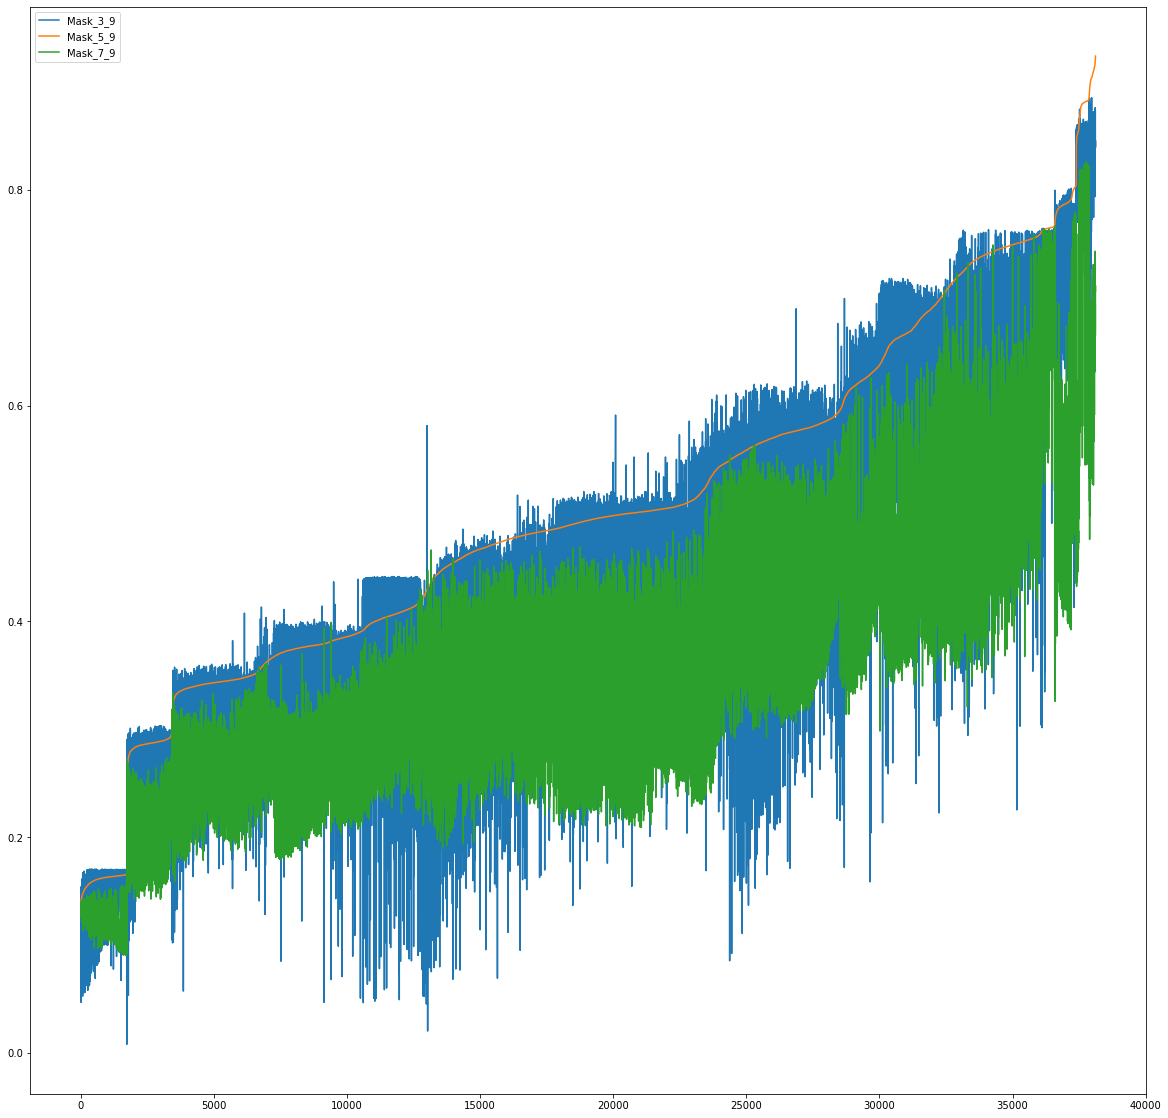

In [10]:
#sort acc
acc.sort(key=lambda x: x[1])

#plot acc as a line graph with the x-axis being the number of iterations and the y-axis being the accuracy
plt.figure(figsize=(20, 20))
plt.plot(np.arange(len(acc)), np.array(acc)[:,0], label="Mask_3_9")
plt.plot(np.arange(len(acc)), np.array(acc)[:,1], label="Mask_5_9")
plt.plot(np.arange(len(acc)), np.array(acc)[:,2], label="Mask_7_9")
plt.legend()
plt.show()

In [6]:
#save acc as a csv file
np.savetxt("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\acc.csv", np.array(acc), delimiter=",")

In [ ]:
#write a function that takes img as input and performs meanshift segmentation on it
def meanshift_segmentation(img):
    #convert img to float32
    img = np.float32(img)

    #reshape img to a 2D array
    img = img.reshape((-1, 3))

    #define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret, label, center = cv2.kmeans(img, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    #convert center to uint8 and reshape back to the original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    return res2

# Deep Learning Methodology

Desigining a model and input pipeline for the data

### Imports

In [4]:
#load the dataset
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
#import keras
#from keras.models import Model
#from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
#from keras.layers import  Dropout, Activation
#from keras.optimizers import Adam, SGD
#from keras.layers.advanced_activations import LeakyReLU
#from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#from keras import backend as K
#from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import pandas as pd
#dataset = tf.data.Dataset.load("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\SkyDataset")

### Input Pipeline

Only run to create the dataset

In [5]:
#set tensorflow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

#create a function that imports image_paths.csv and converts it into a tf.data.Dataset
def get_dataset(image_paths, label_paths):

    def _parse_function(image_path, label_path):

        image_string = tf.io.read_file(image_path)
        label_string = tf.io.read_file(label_path)

        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        label_decoded = tf.image.decode_png(label_string, channels=1)

        image_decoded = tf.cast(image_decoded, tf.int32)
        label_decoded = tf.where(label_decoded > 0, 1, 0)
        return image_decoded, label_decoded

    epoch_size = len(image_paths)
    image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
    label_paths = tf.convert_to_tensor(label_paths, dtype=tf.string)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(_parse_function, num_parallel_calls=8)

    return dataset

#import image_paths.csv into a dataframe
df = pd.read_csv("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\image_paths.csv")
image_paths = df["image_path"].tolist()
label_paths = df["label"].tolist()

#load the dataset
dataset = get_dataset(image_paths, label_paths)

#shuffle dataset
dataset = dataset.shuffle(10000)

#split the dataset into train and test
test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)

#print the length of the dataset
print(len(dataset))

#save the dataset as a file
#tf.data.Dataset.save(dataset, "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\SkyDataset")

38115


(480, 640, 3)


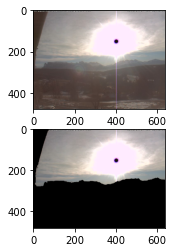

In [6]:
#print first 5 images in the dataset
for image, label in dataset.take(1):
    #mask the image with the label
    image_masked = image * label # type: ignore

    print(image_masked.shape)

    plt.figure(1)
    plt.subplot(2,1,1)
    plt.imshow(image)
    #plt.subplot(2,1,2)
    #plt.imshow(label)
    plt.subplot(2,1,2)
    plt.imshow(image_masked)
    plt.show()

In [36]:
#create a unet model that trains on the dataset
def unet(input_size=(480, 640, 3)):
    

37115